In [22]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from keras.preprocessing.image import ImageDataGenerator
np.random.seed(7)

import os
from glob import glob
import seaborn as sns
from PIL import Image

from sklearn.metrics import accuracy_score
import itertools
import keras 
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.layers import BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam, RMSprop

from keras.callbacks import ReduceLROnPlateau
from scikeras.wrappers import KerasClassifier
from keras.applications.resnet50 import ResNet50


Loading and Preprocessing Using ImageDataGenerator

In [2]:
from keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for training and validation data
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Rescale images and split for validation

test_datagen=ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    directory='train',
    target_size=(224, 224),  # Resizing images to a uniform size
    batch_size=32,
    class_mode='binary',  # For binary classification
    subset='training'  # Specify the subset as 'training'
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    directory='train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify the subset as 'validation'
)

test_generator = test_datagen.flow_from_directory(
    directory='test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
  
)


Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [23]:
train_benign='train/benign'
train_malignant='train/malignant'
test_malignant='test/malignant'
test_benign='test/benign'

In [24]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Loading training pictures 
image_benign = [read(os.path.join(train_benign, filename)) for filename in os.listdir(train_benign)]
X_benign = np.array(image_benign, dtype='uint8')
image_malignant = [read(os.path.join(train_malignant, filename)) for filename in os.listdir(train_malignant)]
X_malignant = np.array(image_malignant, dtype='uint8')

# Loading testing pictures
ims_benign = [read(os.path.join(test_benign, filename)) for filename in os.listdir(test_benign)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(test_malignant, filename)) for filename in os.listdir(test_malignant)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

In [25]:
# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Combine data into splits
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
Y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
Y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

In [26]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [27]:
# Assuming Y_train and Y_test are your label arrays
print("Unique labels in Y_train:", np.unique(Y_train))
print("Shape of Y_train:", Y_train.shape)

print("Unique labels in Y_test:", np.unique(Y_test))
print("Shape of Y_test:", Y_test.shape)


Unique labels in Y_train: [0. 1.]
Shape of Y_train: (2637,)
Unique labels in Y_test: [0. 1.]
Shape of Y_test: (660,)


In [28]:
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [29]:
X_train = X_train/255.
X_test = X_test/255.

Display images

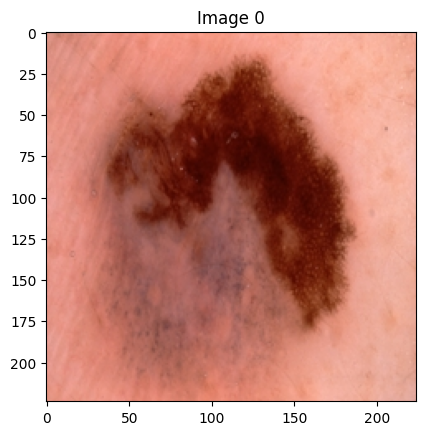

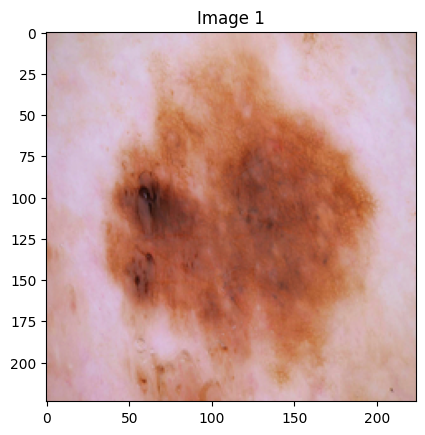

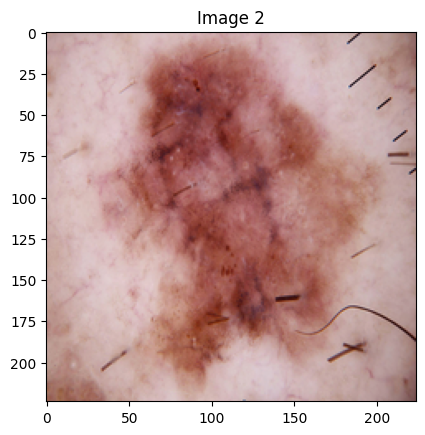

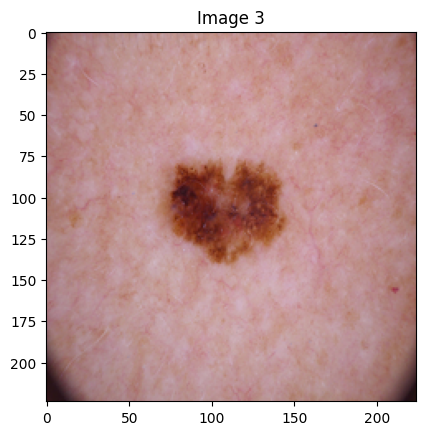

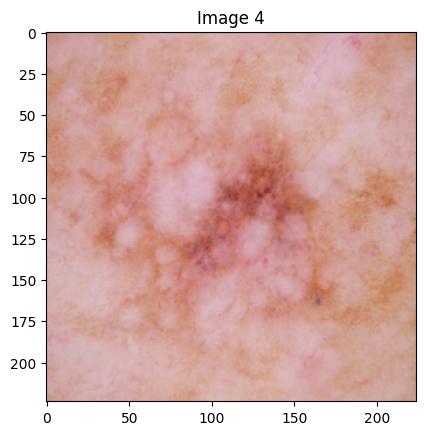

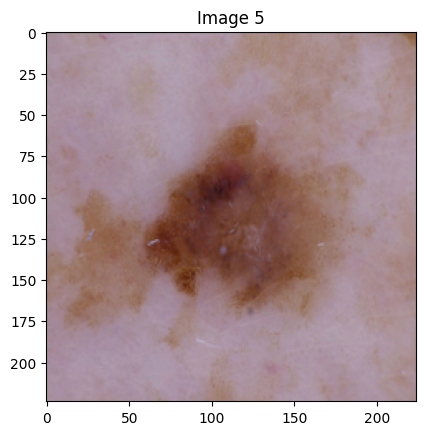

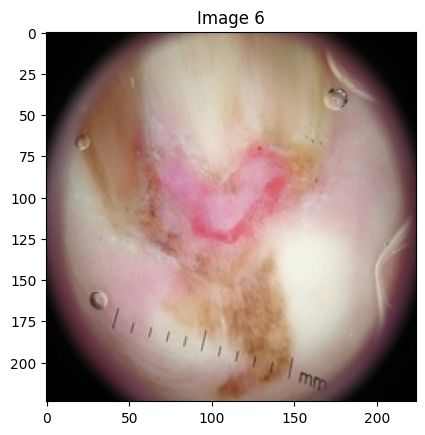

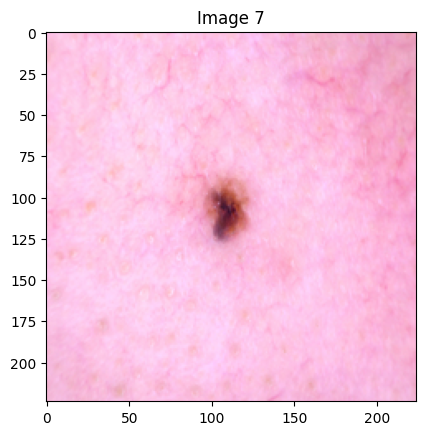

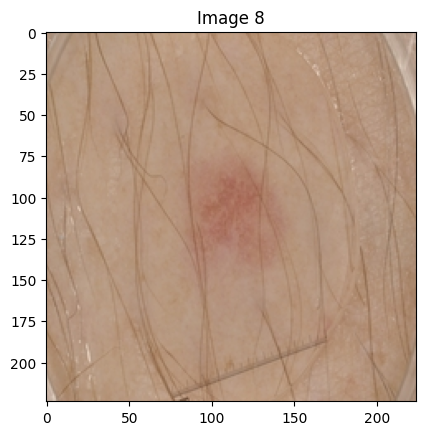

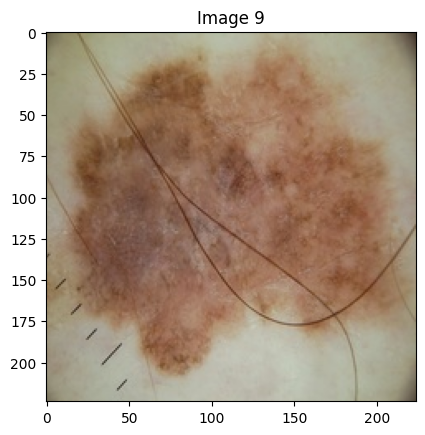

In [30]:
import matplotlib.pyplot as plt

num_images = 10  

for i in range(num_images):
    plt.imshow(X_train[i])
    plt.title(f"Image {i}")  # Set a title with the image index
    plt.show()


In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if Y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

TRAINING USING RESNET MODEL BUT WITHOUT THE PRETRAINED WEIGHTS

In [31]:
#Declaring the variables for the model e.g learning rate, beatch size, epochs etc
learning_rate=1.e-5
epochs=50
batch_size=32
input_shape= (224,224,3)

In [32]:
#ReduceLROnPlateau instance so we can monitor accuracy and adjust the learning rate if accuracy stops improving
adjust_rate=ReduceLROnPlateau(monitor='val_accuracy',patience=4,factor=0.5,min_lr=1.e-7)

In [33]:
model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)






In [34]:
model.compile(optimizer = Adam(learning_rate) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

In [36]:
f_model= model.fit(X_train,Y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[adjust_rate]
                   )

MemoryError: Unable to allocate 2.37 GiB for an array with shape (2109, 224, 224, 3) and data type float64

Displyaing the model accuracy and loss

In [37]:
print(f_model.history.keys())
# summarize history for accuracy
plt.plot(f_model.history['accuracy'])
plt.plot(f_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(f_model.history['loss'])
plt.plot(f_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'f_model' is not defined

Saving The First Model

In [12]:
from keras.models import load_model

# Save the model
model.save('skinCancer_Resnetmodel.keras')


NameError: name 'model' is not defined

    Training Another Model Using CNNs

In [13]:
#Model function
def create_model(pool_size=(3,3),kernel_size=(3,3),optimizer='adam',learning_rate=1e-3):
    model=Sequential()
    model.add(Conv2D(64,kernel_size=kernel_size,padding='same',input_shape=input_shape,activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(64,kernel_size=kernel_size,padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(rate=0.50))
    #model.add(Conv2D(32,kernel_size=kernel_size,padding='same',activation='relu'))
    #model.add(MaxPooling2D(pool_size=pool_size))
   # model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(24,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    return model

In [14]:
#Keras Classifier
k_model=KerasClassifier(model=create_model,epochs=50,batch_size=10,verbose=0)

In [15]:
parameter={'model__pool_size':[(2,3),(3,4)],
'model__kernel_size':[(4,3),(4,4)],
'model__optimizer':['sgd','rmsprop'],
'model__learning_rate':[1e-5]}

In [16]:
from sklearn.model_selection import StratifiedKFold
cv=StratifiedKFold(n_splits=3,shuffle=True)

In [17]:
has_nan_train = np.isnan(Y_train).any()
has_nan_test = np.isnan(Y_test).any()
print("NaN values in training labels:", has_nan_train)
print("NaN values in test labels:", has_nan_test)


NaN values in training labels: False
NaN values in test labels: False


In [18]:
print(Y_train.shape)
print("Unique labels in Y_train:", np.unique(Y_train))
# Check the shape of training labels
print(Y_test.shape)   # Check the shape of test labels


(2637, 2)
Unique labels in Y_train: [0. 1.]
(660, 2)
